# Britain - Airborne total-field magnetic anomaly

This is a digitized version of an airborne magnetic survey of Britain. Data are
sampled where flight lines crossed contours on the archive maps. Contains only
the total field magnetic anomaly, not the magnetic field intensity measurements
or corrections.

**Source:** [British Geological Survey](https://www.bgs.ac.uk/datasets/gb-aeromagnetic-survey/)

**License:** [Open Government Licence](https://www.bgs.ac.uk/bgs-intellectual-property-rights/open-government-licence/)

Contains British Geological Survey materials © UKRI 2021.

## Notes

Flight height is estimated and not specified if it's geometric or orthometric. Given the error involved in how the data were digitized, it likely doesn't matter which. The horizontal datum is OSGB36 (epsg:27700) and we convert the data to WGS84 for standardization.

In [1]:
import os
import numpy as np
import pandas as pd
import verde as vd
import pooch
import pyproj
import pygmt

## Download the data

Use [Pooch](https://github.com/fatiando/pooch) to download the original data file to our computer.

In [2]:
fnames = pooch.retrieve(
    url="https://www.bgs.ac.uk/?wpdmdl=11839",
    fname="britain-aeromag.zip",
    known_hash="md5:e9968928e1c156bfe318bfb84657a472",
    # Unpack and return only the actual data, not the reports.
    processor=pooch.Unzip(members=["Aeromag_csv/aeromag.csv"]),
)
fname = fnames[0]
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

size: 43.499991 Mb


## Read the data

Use pandas to read the data.

In [3]:
data = pd.read_csv(
    fname, 
    usecols=[0, 1, 4, 5, 10, 13], 
    header=0,
    names=["survey", "line_and_segment", "longitude_osgb", "latitude_osgb", "height_m", "total_field_anomaly_nt"],
)
data

survey line_and_segment  longitude_osgb  latitude_osgb  height_m  \
0       CA55_NORTH            FL1-1        -1.74012       53.48138       792   
1       CA55_NORTH            FL1-1        -1.69972       53.48326       663   
2       CA55_NORTH            FL1-1        -1.07893       53.47650       315   
3       CA55_NORTH            FL1-1        -1.07313       53.47645       315   
4       CA55_NORTH            FL1-1        -1.01604       53.47559       321   
...            ...              ...             ...            ...       ...   
541503        HG65  FL-3(TL10-24)-1        -4.68710       58.26822      1031   
541504        HG65  FL-3(TL10-24)-1        -4.68517       58.26822      1045   
541505        HG65  FL-3(TL10-24)-1        -4.68402       58.26826      1035   
541506        HG65  FL-3(TL10-24)-1        -4.68286       58.26823      1024   
541507        HG65  FL-3(TL10-24)-1        -4.68141       58.26826      1011   

        total_field_anomaly_nt  
0                           62  
1                           56  
2                           30  
3                           31  
4                           44  
...                        ...  
541503                      64  
541504                      74  
541505                      94  
541506                     114  
541507                     120  

[541508 rows x 6 columns]

## Extract the year information from the survey area field

The year is encoded in the `survey` variable. Split it up and make it a separate field.

In [4]:
data["year"] = data.survey.map(lambda x: int(x.split("_")[0][2:]) + 1900)
data

survey line_and_segment  longitude_osgb  latitude_osgb  height_m  \
0       CA55_NORTH            FL1-1        -1.74012       53.48138       792   
1       CA55_NORTH            FL1-1        -1.69972       53.48326       663   
2       CA55_NORTH            FL1-1        -1.07893       53.47650       315   
3       CA55_NORTH            FL1-1        -1.07313       53.47645       315   
4       CA55_NORTH            FL1-1        -1.01604       53.47559       321   
...            ...              ...             ...            ...       ...   
541503        HG65  FL-3(TL10-24)-1        -4.68710       58.26822      1031   
541504        HG65  FL-3(TL10-24)-1        -4.68517       58.26822      1045   
541505        HG65  FL-3(TL10-24)-1        -4.68402       58.26826      1035   
541506        HG65  FL-3(TL10-24)-1        -4.68286       58.26823      1024   
541507        HG65  FL-3(TL10-24)-1        -4.68141       58.26826      1011   

        total_field_anomaly_nt  year  
0                           62  1955  
1                           56  1955  
2                           30  1955  
3                           31  1955  
4                           44  1955  
...                        ...   ...  
541503                      64  1965  
541504                      74  1965  
541505                      94  1965  
541506                     114  1965  
541507                     120  1965  

[541508 rows x 7 columns]

## Transform to WGS84

Transform the horizontal datum from OSGB36 to WGS84. See [this StackOverflow answer for the transformation](https://stackoverflow.com/a/1434973).

In [5]:
osgb = pyproj.CRS.from_proj4("+proj=latlong +ellps=airy +no_defs +towgs84=446.448,-125.157,542.060,0.1502,0.2470,0.8421,-20.4894")
wgs84 = pyproj.CRS.from_epsg(4326)
transformer = pyproj.Transformer.from_crs(osgb, wgs84, always_xy=True)

In [6]:
data["longitude"], data["latitude"] = transformer.transform(data.longitude_osgb, data.latitude_osgb)

In [7]:
data

survey line_and_segment  longitude_osgb  latitude_osgb  height_m  \
0       CA55_NORTH            FL1-1        -1.74012       53.48138       792   
1       CA55_NORTH            FL1-1        -1.69972       53.48326       663   
2       CA55_NORTH            FL1-1        -1.07893       53.47650       315   
3       CA55_NORTH            FL1-1        -1.07313       53.47645       315   
4       CA55_NORTH            FL1-1        -1.01604       53.47559       321   
...            ...              ...             ...            ...       ...   
541503        HG65  FL-3(TL10-24)-1        -4.68710       58.26822      1031   
541504        HG65  FL-3(TL10-24)-1        -4.68517       58.26822      1045   
541505        HG65  FL-3(TL10-24)-1        -4.68402       58.26826      1035   
541506        HG65  FL-3(TL10-24)-1        -4.68286       58.26823      1024   
541507        HG65  FL-3(TL10-24)-1        -4.68141       58.26826      1011   

        total_field_anomaly_nt  year  longitude   latitude  
0                           62  1955  -1.741619  53.481635  
1                           56  1955  -1.701224  53.483516  
2                           30  1955  -1.080508  53.476766  
3                           31  1955  -1.074709  53.476716  
4                           44  1955  -1.017626  53.475857  
...                        ...   ...        ...        ...  
541503                      64  1965  -4.688428  58.267865  
541504                      74  1965  -4.686498  58.267865  
541505                      94  1965  -4.685348  58.267905  
541506                     114  1965  -4.684188  58.267875  
541507                     120  1965  -4.682738  58.267905  

[541508 rows x 9 columns]

The difference is very small but we may as well do it.

## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

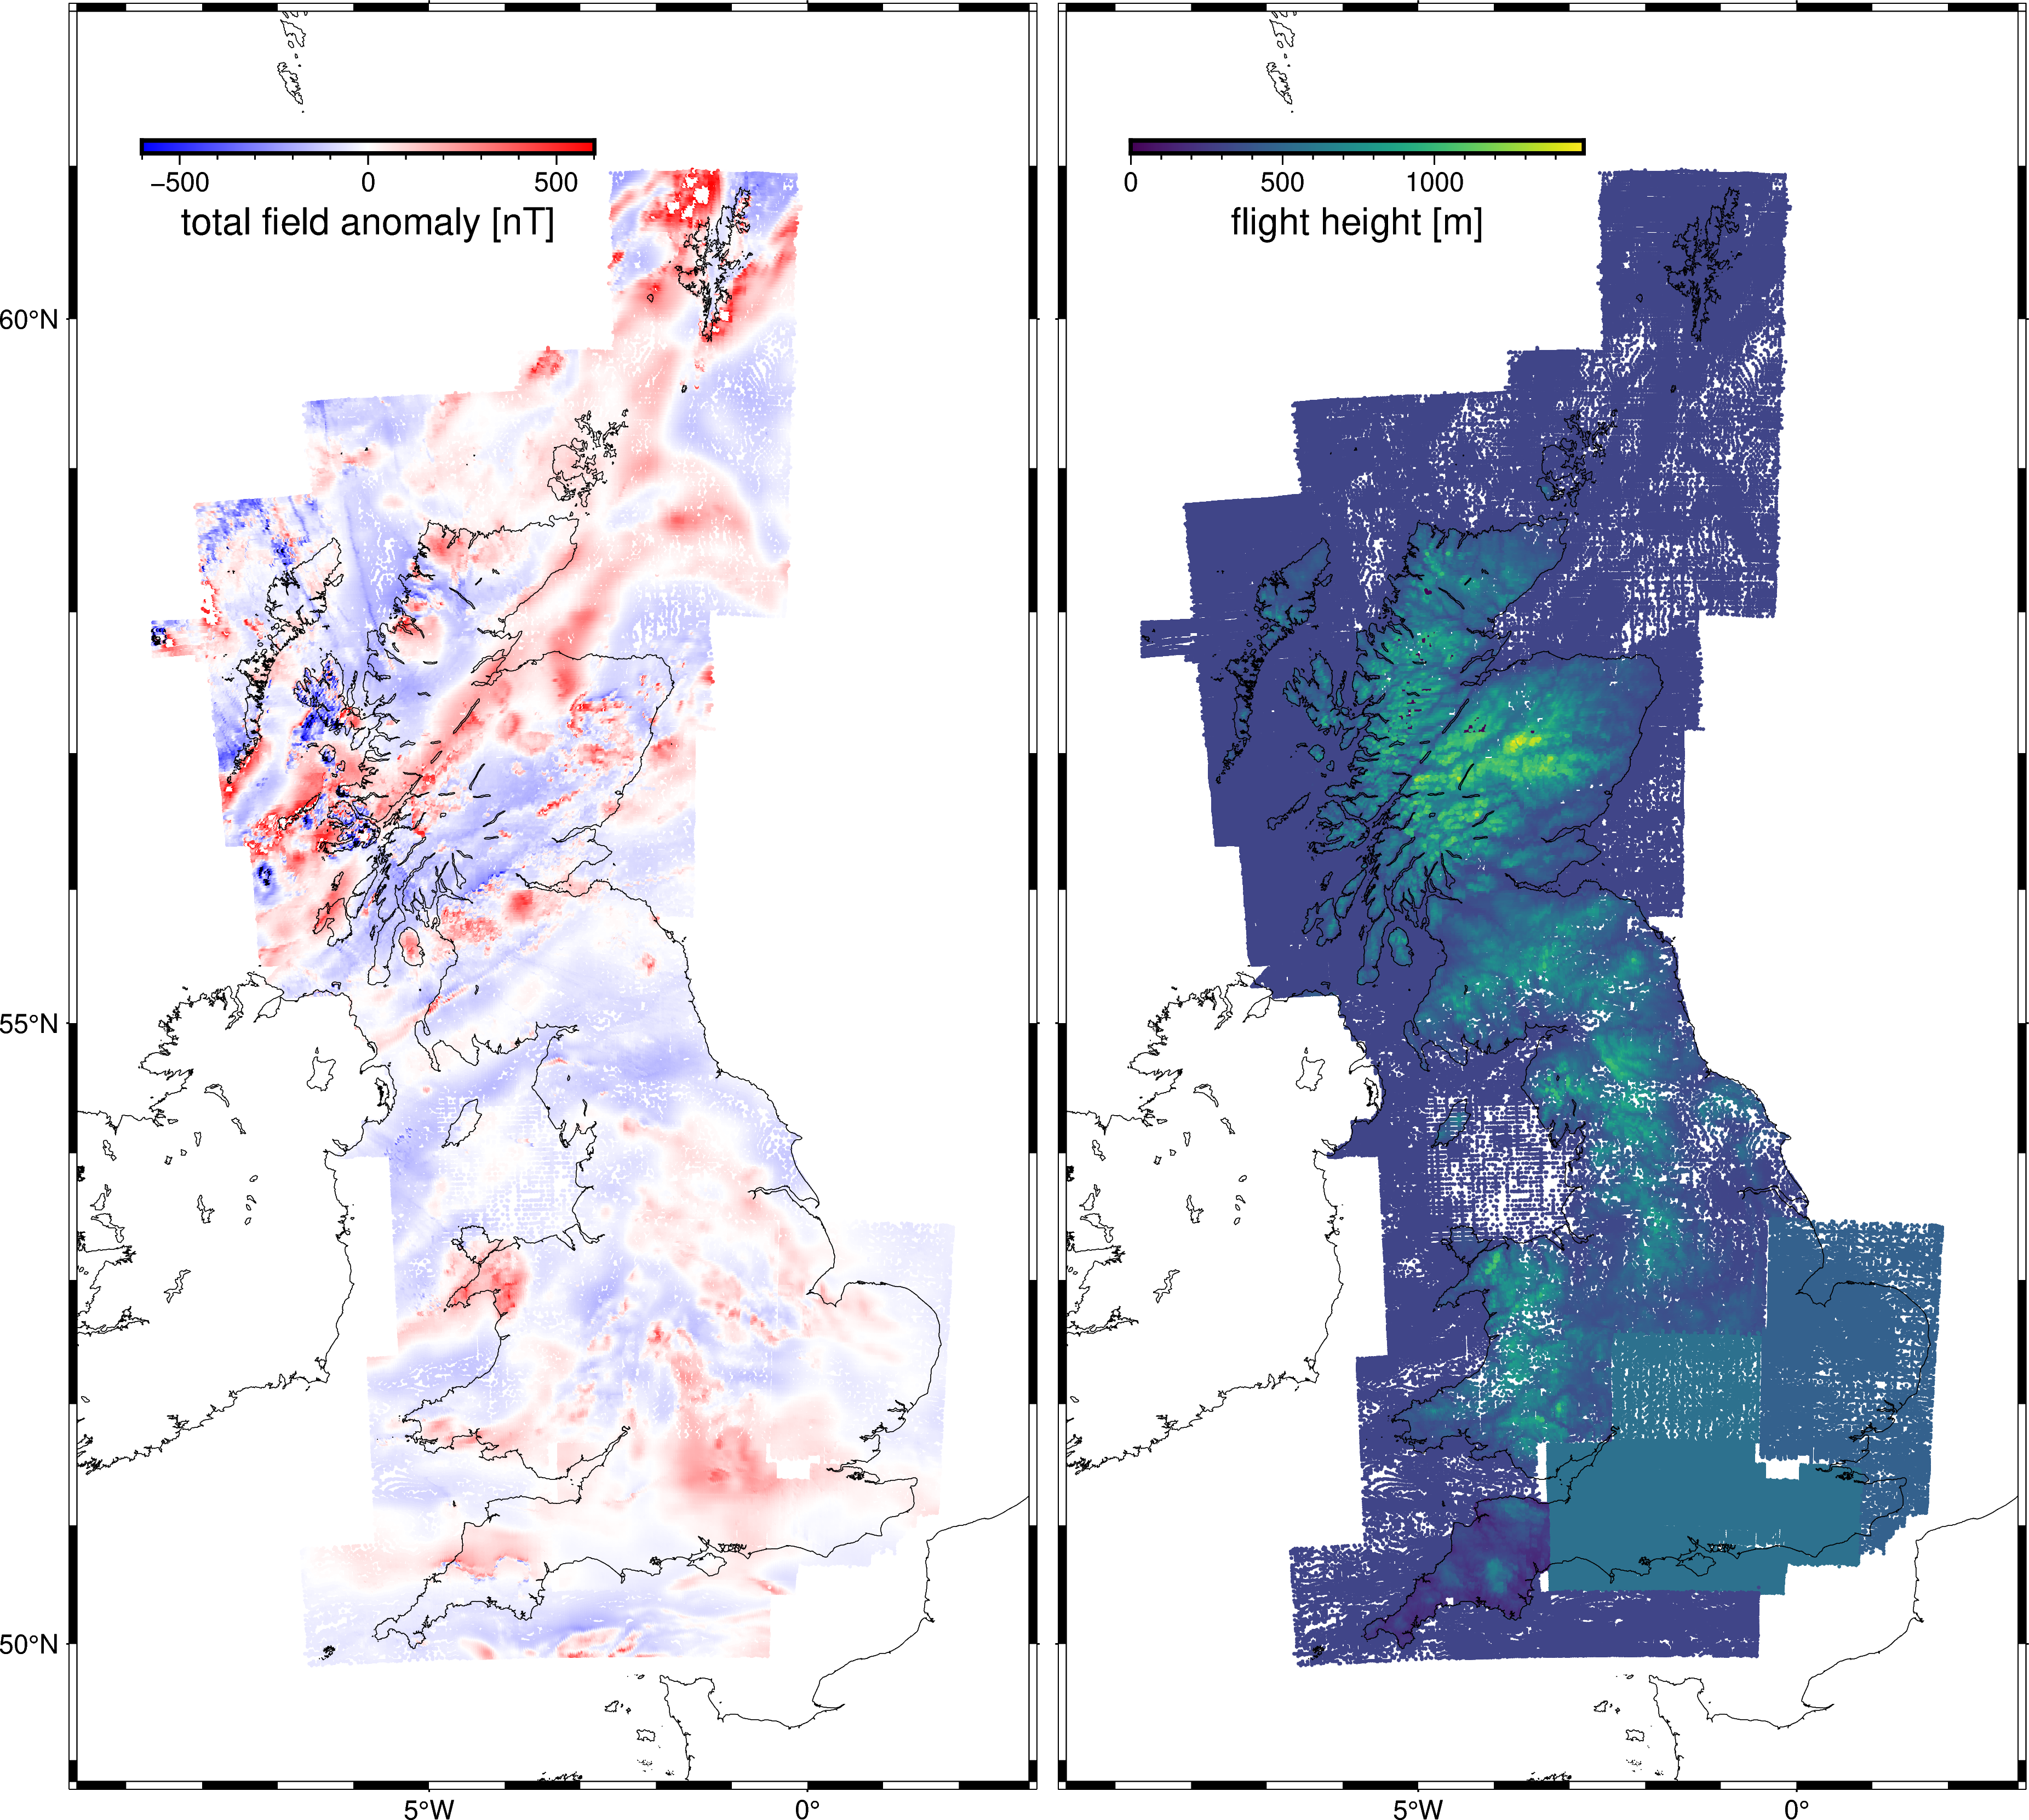

In [8]:
region = vd.pad_region(vd.get_region((data.longitude, data.latitude)), pad=1)

fig = pygmt.Figure()
with fig.subplot(
    nrows=1,
    ncols=2,
    figsize=("30c", "30c"),
    sharey="l",  # shared y-axis on the left side
    frame="WSrt",
):
    with fig.set_panel(0):
        fig.basemap(frame="af", projection="M?", region=region)
        scale = np.percentile(data.total_field_anomaly_nt, 99)
        pygmt.makecpt(cmap="polar", series=[-scale, scale])
        fig.plot(x=data.longitude, y=data.latitude, style="c0.05c", color=data.total_field_anomaly_nt, cmap=True)
        fig.colorbar(frame='af+l"total field anomaly [nT]"', position="jTL+h+w7c/0.2c+o1/2")
        fig.coast(shorelines=True)
    with fig.set_panel(1):
        fig.basemap(frame="af", projection="M?", region=region)
        pygmt.makecpt(cmap="viridis", series=[data.height_m.min(), data.height_m.max()])
        fig.plot(x=data.longitude, y=data.latitude, style="c0.05c", color=data.height_m, cmap=True)
        fig.colorbar(frame='af+l"flight height [m]"', position="jTL+h+w7c/0.2c+o1/2")
        fig.coast(shorelines=True)
fig.savefig("preview.jpg", dpi=200)
fig.show(width=1000)

## Export

Make a separate DataFrame to export to a compressed CSV. The conversion is needed to specify the number of significant digits to preserve in the output. Setting this along with the LZMA compression can help reduce the file size considerably. Not all fields in the original data need to be exported.

In [9]:
export = pd.DataFrame({  
    "line_and_segment": data.line_and_segment, 
    "year": data.year.map(lambda x: "{:d}".format(x)),  
    "longitude": data.longitude.map(lambda x: "{:.5f}".format(x)),
    "latitude": data.latitude.map(lambda x: "{:.5f}".format(x)),    
    "height_m": data.height_m.map(lambda x: "{:.0f}".format(x)),    
    "total_field_anomaly_nt": data.total_field_anomaly_nt.map(lambda x: "{:.0f}".format(x)), 
})
export

line_and_segment  year longitude  latitude height_m  \
0                 FL1-1  1955  -1.74162  53.48164      792   
1                 FL1-1  1955  -1.70122  53.48352      663   
2                 FL1-1  1955  -1.08051  53.47677      315   
3                 FL1-1  1955  -1.07471  53.47672      315   
4                 FL1-1  1955  -1.01763  53.47586      321   
...                 ...   ...       ...       ...      ...   
541503  FL-3(TL10-24)-1  1965  -4.68843  58.26786     1031   
541504  FL-3(TL10-24)-1  1965  -4.68650  58.26786     1045   
541505  FL-3(TL10-24)-1  1965  -4.68535  58.26790     1035   
541506  FL-3(TL10-24)-1  1965  -4.68419  58.26787     1024   
541507  FL-3(TL10-24)-1  1965  -4.68274  58.26790     1011   

       total_field_anomaly_nt  
0                          62  
1                          56  
2                          30  
3                          31  
4                          44  
...                       ...  
541503                     64  
541504                     74  
541505                     94  
541506                    114  
541507                    120  

[541508 rows x 6 columns]

Save the data to a file and calculate the size and MD5/SHA256 hashes.

In [10]:
output = "britain-magnetic.csv.xz"
export.to_csv(output, index=False)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: britain-magnetic.csv.xz
size: 2.669264 Mb
md5:8dbbda02c7e74f63adc461909358f056
sha256:4e00894c2e0fa5b9c547719c8ac08adb6e788a7074c0dae9fb1b2767cf494b38


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [11]:
data_reloaded = pd.read_csv(output)
data_reloaded

line_and_segment  year  longitude  latitude  height_m  \
0                 FL1-1  1955   -1.74162  53.48164       792   
1                 FL1-1  1955   -1.70122  53.48352       663   
2                 FL1-1  1955   -1.08051  53.47677       315   
3                 FL1-1  1955   -1.07471  53.47672       315   
4                 FL1-1  1955   -1.01763  53.47586       321   
...                 ...   ...        ...       ...       ...   
541503  FL-3(TL10-24)-1  1965   -4.68843  58.26786      1031   
541504  FL-3(TL10-24)-1  1965   -4.68650  58.26786      1045   
541505  FL-3(TL10-24)-1  1965   -4.68535  58.26790      1035   
541506  FL-3(TL10-24)-1  1965   -4.68419  58.26787      1024   
541507  FL-3(TL10-24)-1  1965   -4.68274  58.26790      1011   

        total_field_anomaly_nt  
0                           62  
1                           56  
2                           30  
3                           31  
4                           44  
...                        ...  
541503                      64  
541504                      74  
541505                      94  
541506                     114  
541507                     120  

[541508 rows x 6 columns]

Make the figure again but don't save it to a file this time.

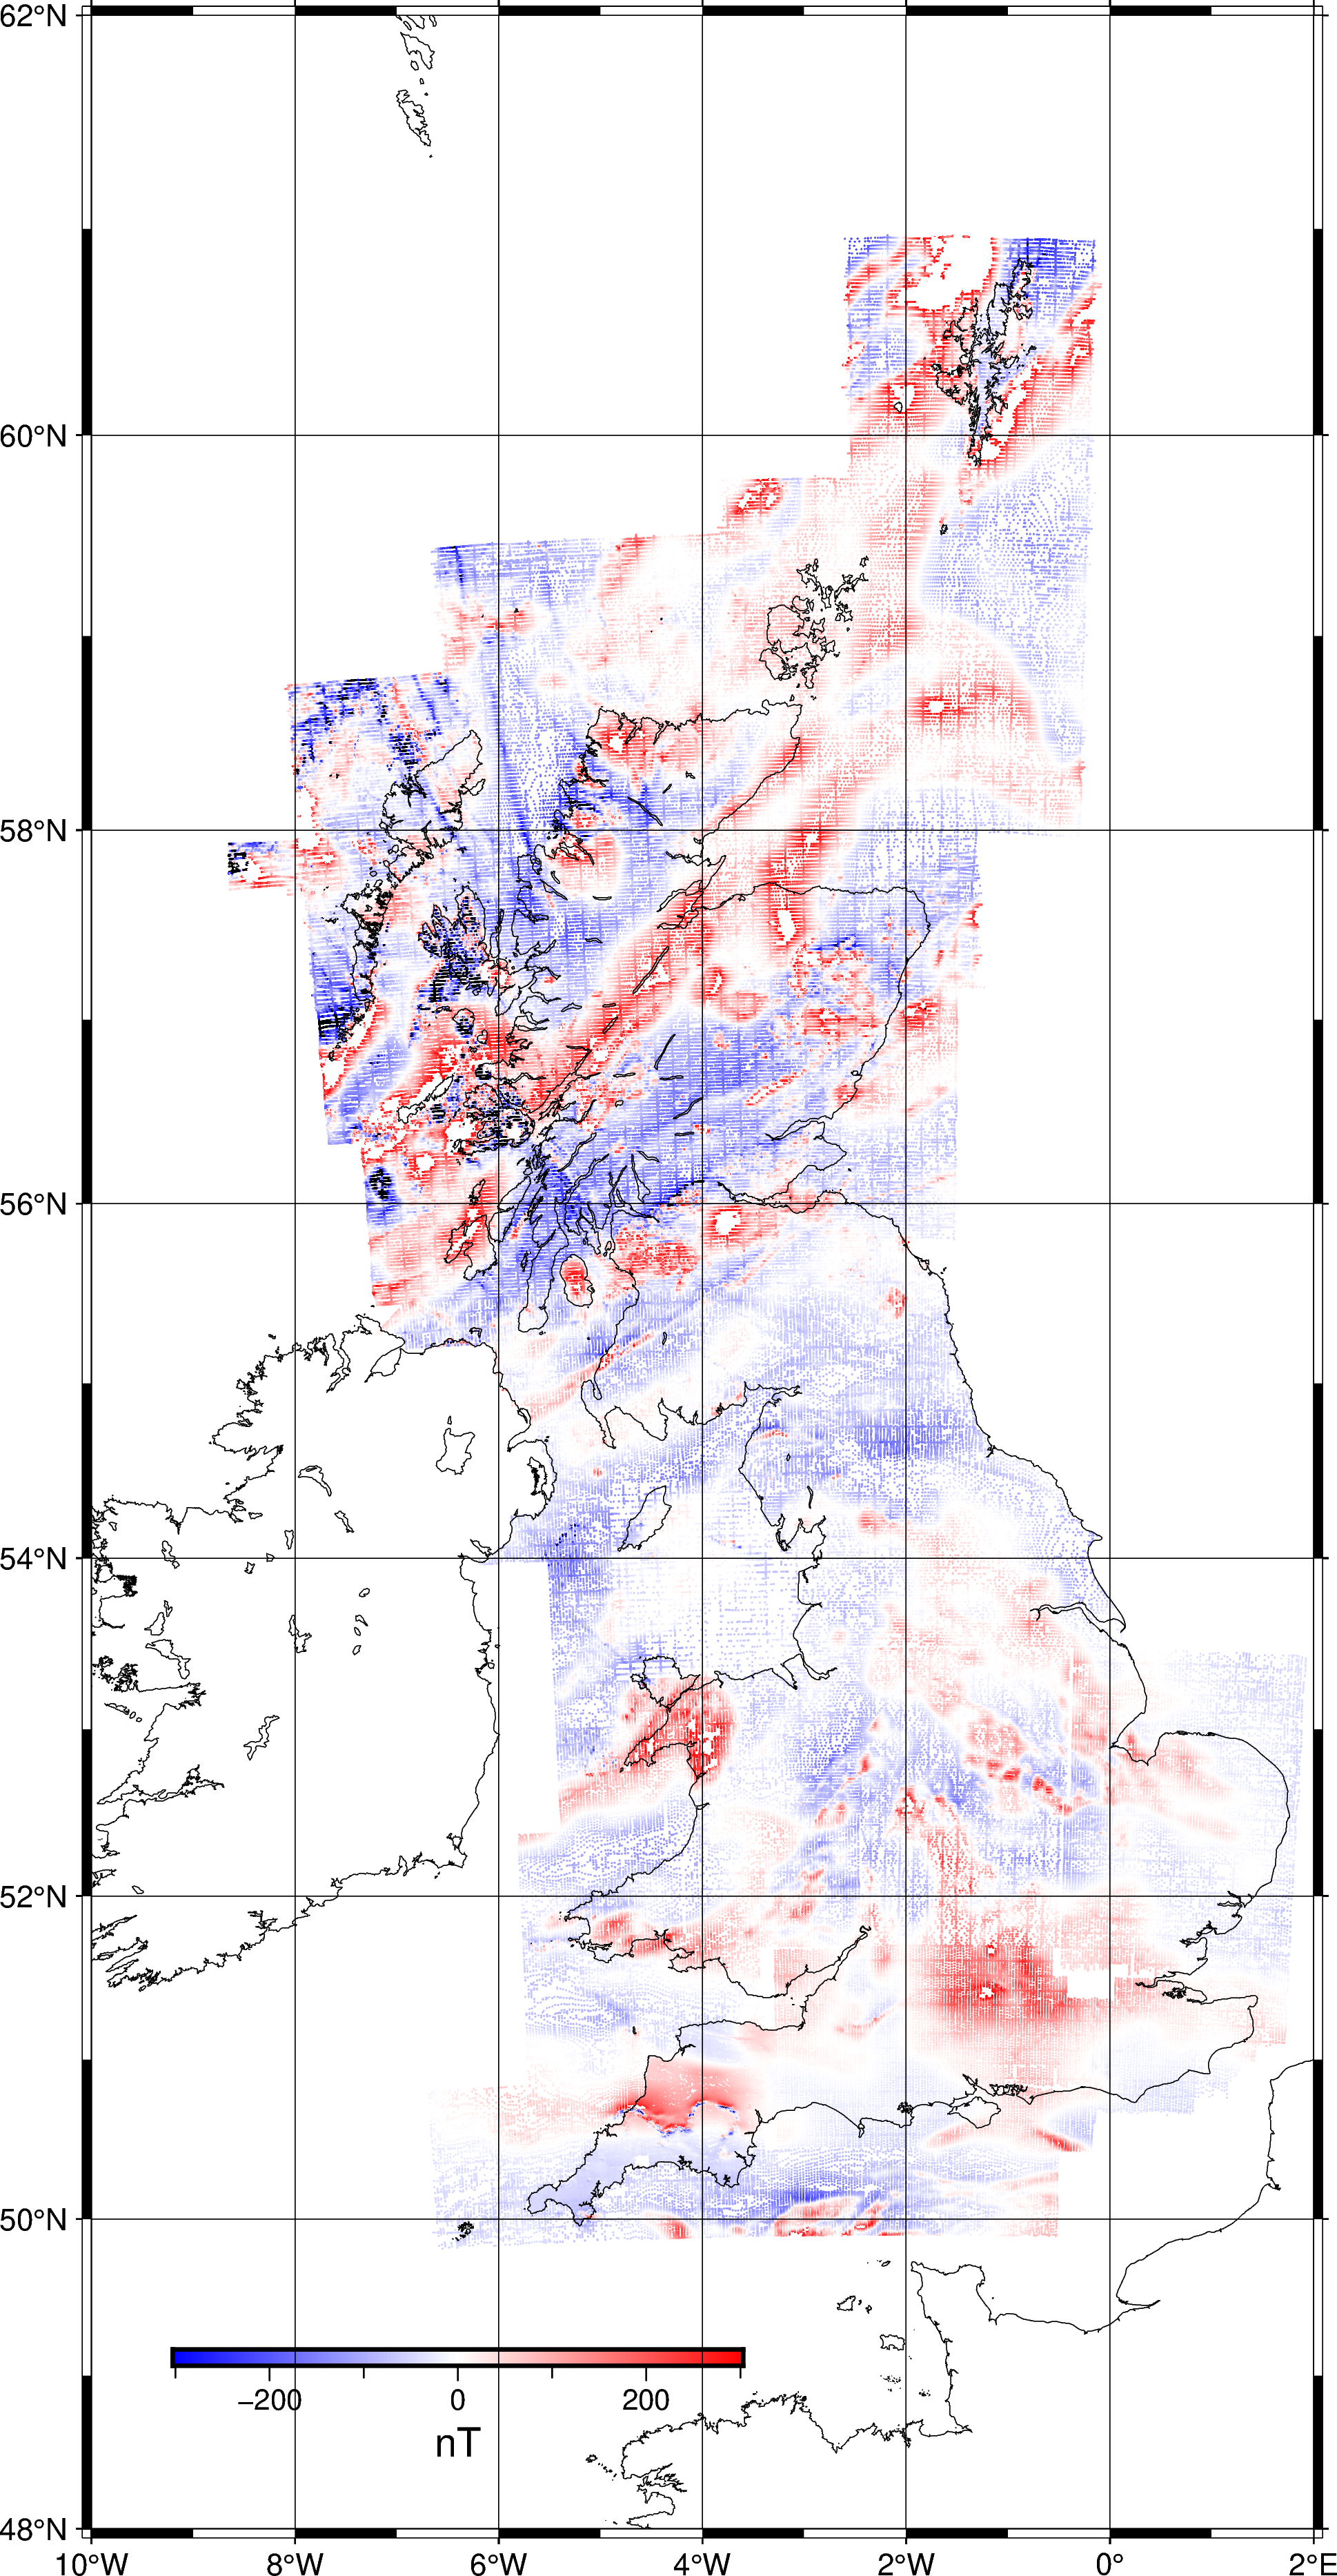

In [12]:
fig = pygmt.Figure()
scale = np.percentile(data_reloaded.total_field_anomaly_nt, 95)
pygmt.makecpt(cmap="polar", series=[-scale, scale])
fig.plot(x=data_reloaded.longitude, y=data_reloaded.latitude, style="c0.02c", color=data_reloaded.total_field_anomaly_nt, cmap=True, projection="M15c")
fig.colorbar(frame='af+l"nT"', position="jBL+h+w7c/0.2c+o1/2")
fig.coast(shorelines=True)
fig.basemap(frame="afg")
fig.show()